# Weather Music Association ML Model.

Based on the trained models in 7-MusicEmotionVAE and 8-WeatherEmotionFNN, generate the music for the given weather data.

### Author

Takeshi Matsumura

In [1]:
from datetime import date
import matplotlib.pylab as plt
import seaborn as sns
from model.WeatherMusicAssociation import WeatherMusicAssociationModel
from common import common

In [2]:
common.init_notebook()

In [3]:
my_2_palette = [sns.color_palette("rainbow", 5)[0], sns.color_palette("rainbow", 5)[4]]
my_5_palette = sns.color_palette("rainbow", 5)

In [4]:
key_encoding = "onehot"

## Load the trained ML models

In [5]:
model = WeatherMusicAssociationModel(key_encoding)
model.load_trained_models()

## Load the weather data

In [6]:
# The x,y index of the grid to use the data from.
weather_df = model.weather_vae.load_nwp_data()
# Feature engineering, scaling and preparation for VAE is done by the WeatherMusicAssociationModel, so don't do them here.

## Generate daily weather music

Adjust the result_interval_hours as you want (e.g. 1 hour)

In [7]:
start_date = date(2023, 1, 1)
end_date = date(2023, 12, 31)
result_interval_hours = 1

final_df = model.weather_music_association(weather_df, start_date, end_date, result_interval_hours)

In [8]:
print(final_df)

      mean_note_duration       tempo  pitch_range          mode   Valence  \
0               0.801665   84.783600    32.685333  7.409249e-08  0.303359   
1               0.892700   90.498955    36.452339  1.812224e-07  0.292065   
2               1.210215  111.251556    37.449757  2.191578e-08  0.231717   
3               1.423223   93.965042    43.981491  5.226931e-06  0.238983   
4               0.794020   64.850029    50.804333  1.256336e-02  0.349039   
...                  ...         ...          ...           ...       ...   
8743            0.870975   84.551613    42.649117  4.576354e-06  0.305307   
8744            0.726595   73.893082    41.517651  6.868765e-06  0.328292   
8745            0.461680   83.394463    26.184765  8.740672e-09  0.353075   
8746            0.741065   72.206558    44.582779  4.050378e-05  0.331978   
8747            0.476228   71.829727    35.056370  6.302388e-07  0.368754   

       Arousal   date_time mode_str  c5_index  
0     0.333513  2023010100 

In [9]:
final_df.shape

(8748, 9)

In [10]:
va_vars = ['Valence', 'Arousal']
vars = va_vars + model.music_columns
x_vars = [v for v in vars if v not in ['mode', 'c5_index']]

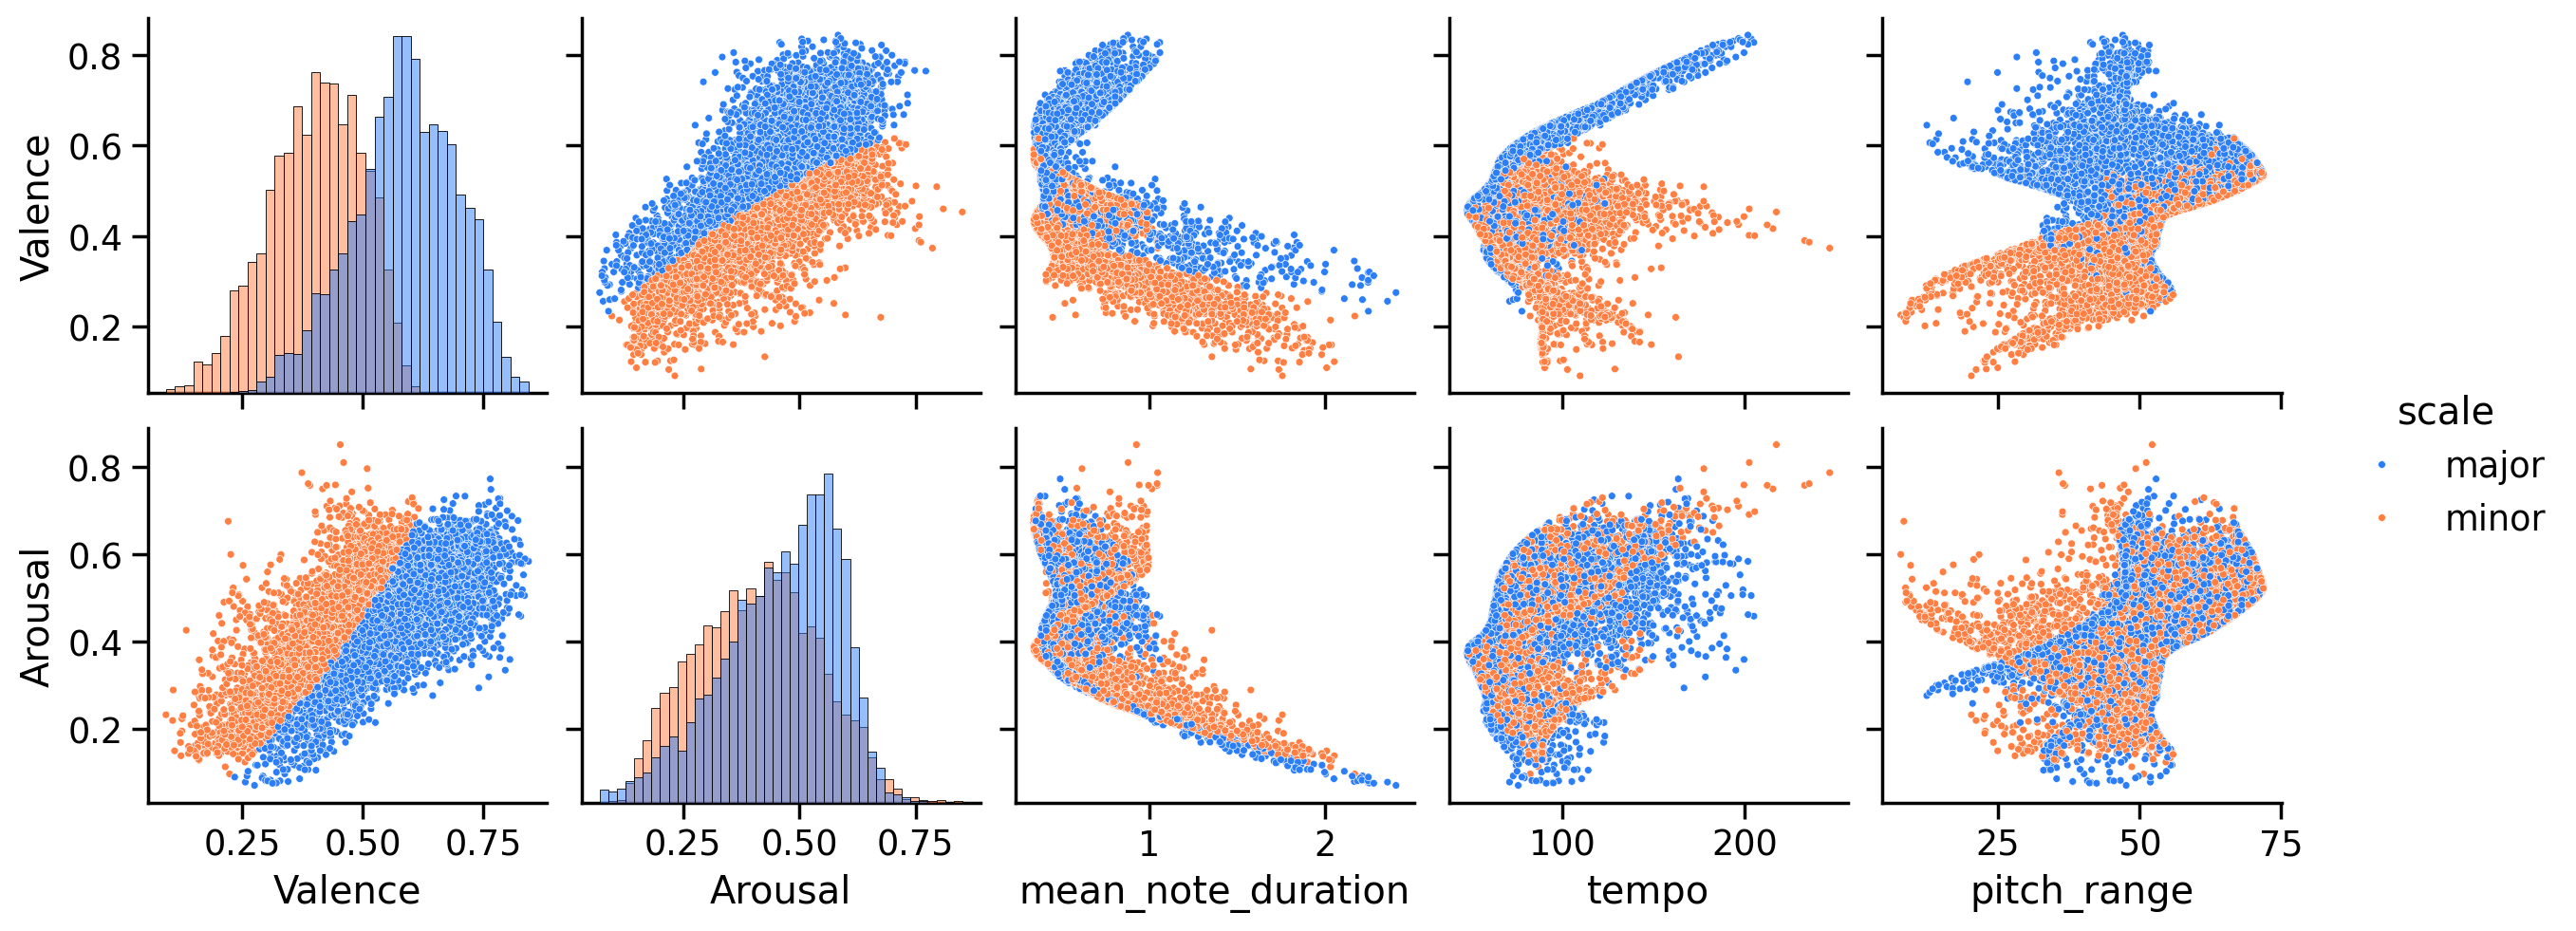

In [11]:
ax = sns.pairplot(final_df, x_vars=x_vars, y_vars = va_vars, diag_kind='hist', plot_kws={'s': 8}, hue='mode_str', hue_order=['major', 'minor'], palette=my_2_palette)
ax._legend.set_title("scale")

Text(0.5, 0, 'Circle of fifths index in minor scale')

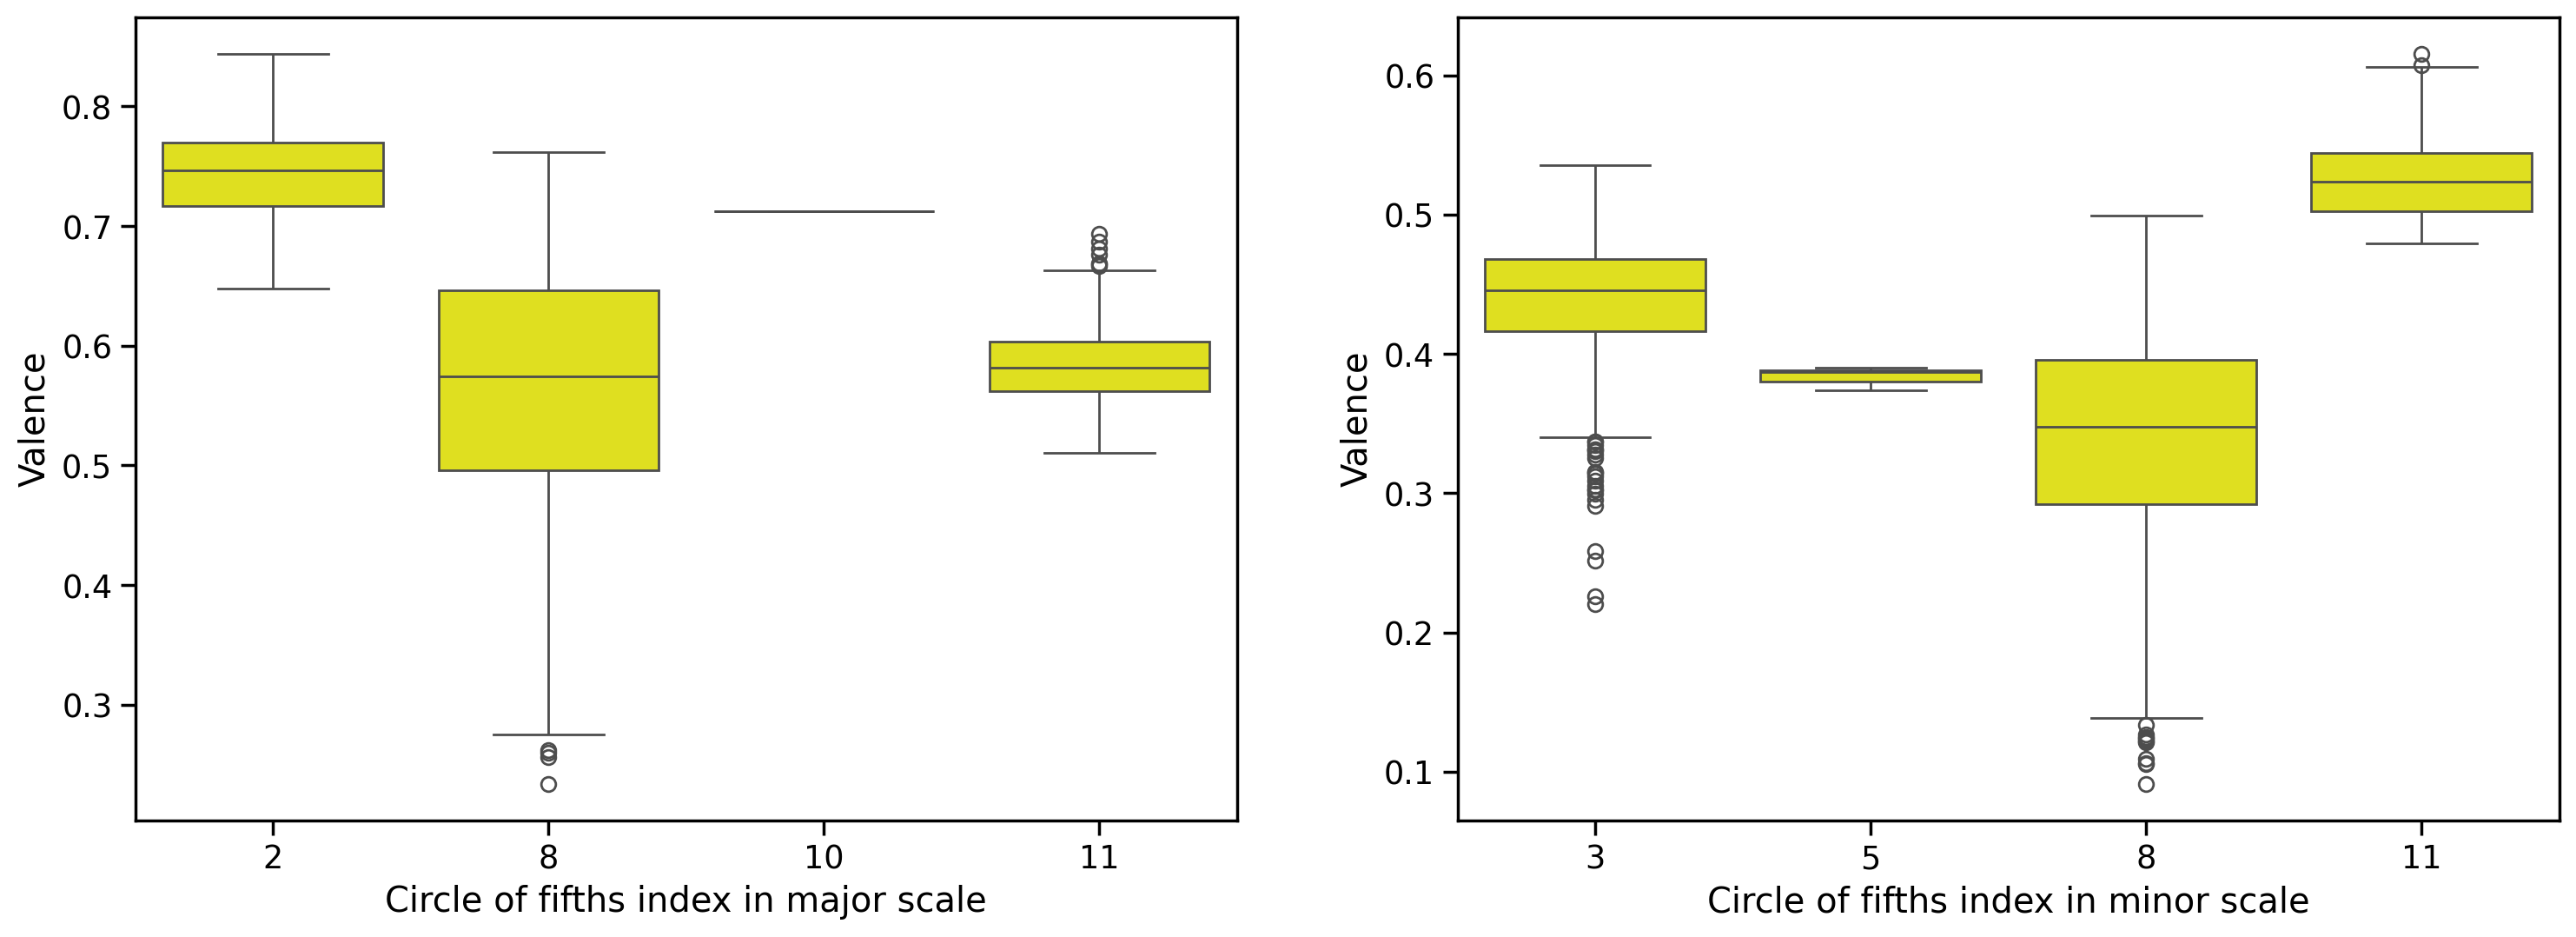

In [12]:
key_col = 'num_accidentals' if key_encoding == 'accidentals' else 'c5_index'
key_col_int = f"{key_col}_int"
key_col_name = "Number of accidentals" if key_encoding == 'accidentals' else "Circle of fifths index"
final_df[key_col_int] = final_df[key_col].round(0)

final_df_major = final_df[final_df['mode_str'] == 'major']
final_df_minor = final_df[final_df['mode_str'] == 'minor']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(x=key_col_int, y='Valence', data=final_df_major, ax=axes[0], color="yellow")
# axes[0].set_xticklabels(pc_names)
axes[0].set_xlabel(f"{key_col_name} in major scale")
sns.boxplot(x=key_col_int, y='Valence', data=final_df_minor, ax=axes[1], color="yellow")
# axes[1].set_xticklabels(pc_names)
axes[1].set_xlabel(f"{key_col_name} in minor scale")

Text(0.5, 0, 'Circle of fifths index in minor scale')

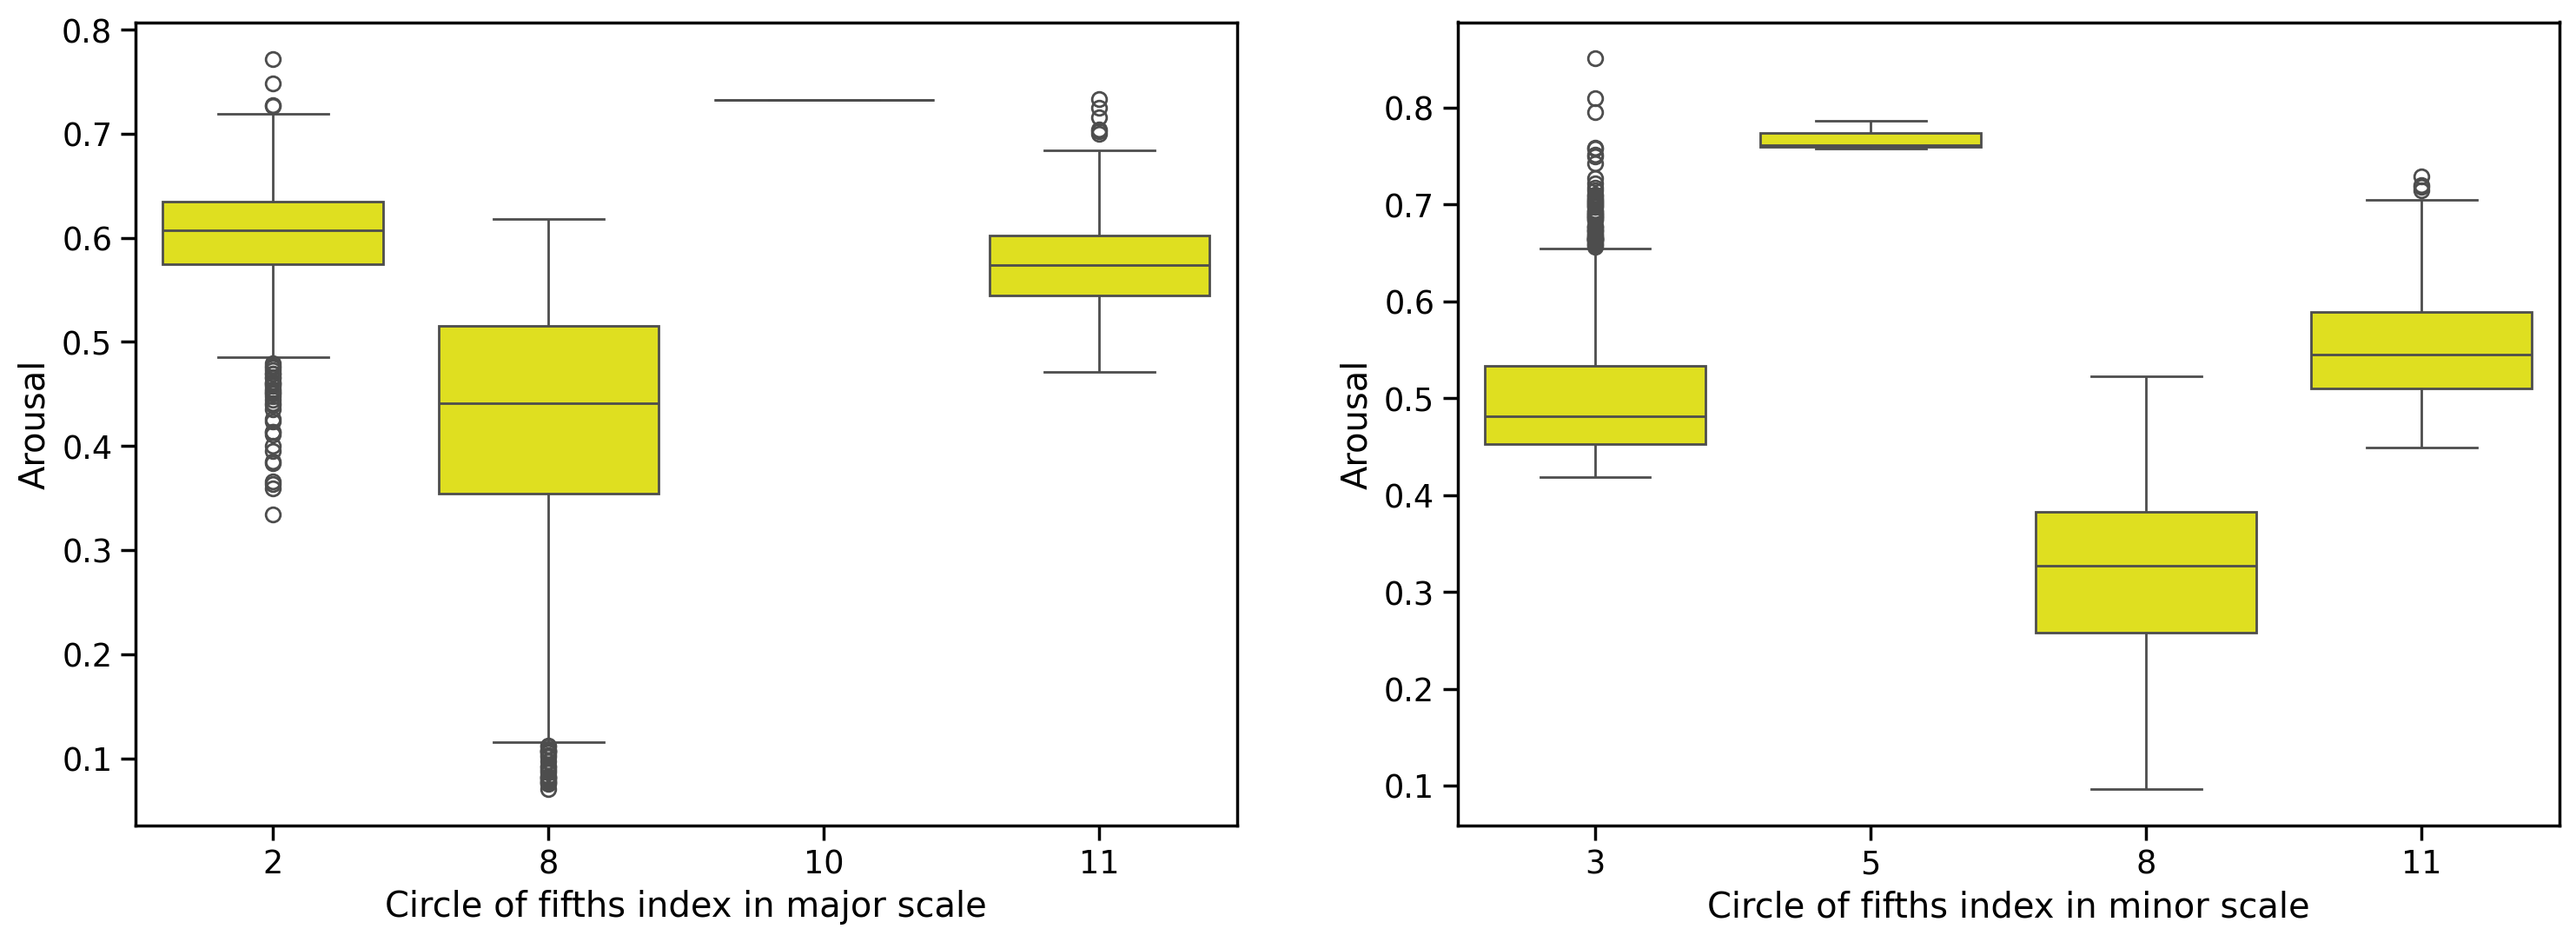

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(x=key_col_int, y='Arousal', data=final_df_major, ax=axes[0], color="yellow")
# axes[0].set_xticklabels(pc_names)
axes[0].set_xlabel(f"{key_col_name} in major scale")
sns.boxplot(x=key_col_int, y='Arousal', data=final_df_minor, ax=axes[1], color="yellow")
# axes[1].set_xticklabels(pc_names)
axes[1].set_xlabel(f"{key_col_name} in minor scale")

In [14]:
# Temporarily disabled the following code because the histplot hangs.

# ax = sns.histplot(final_df['mode'])
# ax.set_xlabel("scale")

In [15]:
# Count the number of major and minor mode samples
major_mode_samples = final_df[final_df['mode'] > model.mode_threshold].shape[0]
minor_mode_samples = final_df[final_df['mode'] <= model.mode_threshold].shape[0]
total_samples = final_df.shape[0]
print("Major scale samples = %d (%.2f%%)" % (major_mode_samples, major_mode_samples / total_samples))
print("Minor scale samples = %d (%.2f%%)" % (minor_mode_samples, minor_mode_samples / total_samples))

# The ratio between the major and minor mode samples are quite different from the prior distribution of MusicEmotionVAE.

Major scale samples = 4595 (0.53%)
Minor scale samples = 4153 (0.47%)


## Save the generated music features for daily weather

In [16]:
model.save_weather_music_features(final_df)